In [50]:
#Import all the libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [51]:
# Defining path of images, image size, and batch size

data_dir = pathlib.Path('./images/').with_suffix('')
batch_size = 32
img_height = 227
img_width = 227



In [52]:
# Split the data into training and validation set using 80-20 split
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 5513 files belonging to 5 classes.
Using 4411 files for training.
Found 5513 files belonging to 5 classes.
Using 1102 files for validation.


In [53]:
# Settings to improve performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [54]:
# Building the CNN architecture

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Rescale the rgb value to [0, 1]
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5, activation='softmax')
])


In [55]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)


Epoch 1/10


138/138 [==============================] - 59s 413ms/step - loss: 1.6902 - accuracy: 0.2988 - val_loss: 1.2928 - val_accuracy: 0.4347
Epoch 2/10
138/138 [==============================] - 57s 416ms/step - loss: 1.1767 - accuracy: 0.5146 - val_loss: 1.0941 - val_accuracy: 0.5590
Epoch 3/10
138/138 [==============================] - 59s 427ms/step - loss: 0.9166 - accuracy: 0.6323 - val_loss: 0.8810 - val_accuracy: 0.6488
Epoch 4/10
138/138 [==============================] - 57s 416ms/step - loss: 0.6444 - accuracy: 0.7581 - val_loss: 0.9729 - val_accuracy: 0.6098
Epoch 5/10
138/138 [==============================] - 57s 416ms/step - loss: 0.4109 - accuracy: 0.8474 - val_loss: 1.1107 - val_accuracy: 0.6624
Epoch 6/10
138/138 [==============================] - 57s 415ms/step - loss: 0.2732 - accuracy: 0.9068 - val_loss: 1.1525 - val_accuracy: 0.6661
Epoch 7/10
138/138 [==============================] - 58s 418ms/step - loss: 0.1549 - accuracy: 0.9472 - val_loss: 1.2077 - val_accuracy: 0.6

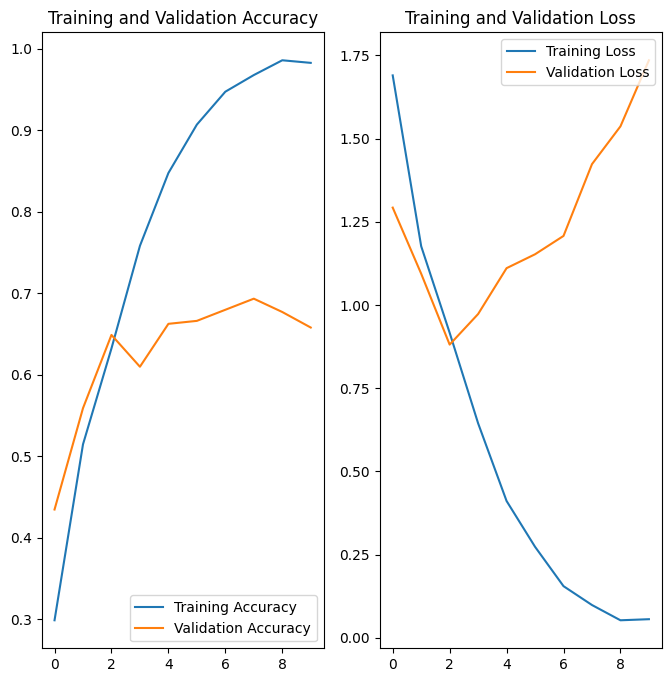

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [57]:
# The data suffers from overfitting which can clearly bee seen from the graphs above. 
# This can be solved by using 
# Data Augmentation (making new images from the given images by transforming them), and
#Dropout(Randomly dropping out some units)

In [58]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.05),
  ]
)


In [61]:
# Adding dropout
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.05),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5, name="outputs", activation='softmax')
])


In [62]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)



Epoch 1/20


138/138 [==============================] - 51s 363ms/step - loss: 1.4945 - accuracy: 0.3401 - val_loss: 1.2315 - val_accuracy: 0.4347
Epoch 2/20
138/138 [==============================] - 51s 373ms/step - loss: 1.1281 - accuracy: 0.5271 - val_loss: 1.0109 - val_accuracy: 0.5980
Epoch 3/20
138/138 [==============================] - 52s 376ms/step - loss: 0.9961 - accuracy: 0.5933 - val_loss: 0.8650 - val_accuracy: 0.6352
Epoch 4/20
138/138 [==============================] - 52s 377ms/step - loss: 0.8182 - accuracy: 0.6760 - val_loss: 0.8406 - val_accuracy: 0.6615
Epoch 5/20
138/138 [==============================] - 52s 376ms/step - loss: 0.7455 - accuracy: 0.7066 - val_loss: 0.6325 - val_accuracy: 0.7559
Epoch 6/20
138/138 [==============================] - 53s 382ms/step - loss: 0.6841 - accuracy: 0.7314 - val_loss: 0.6554 - val_accuracy: 0.7523
Epoch 7/20
138/138 [==============================] - 54s 392ms/step - loss: 0.6282 - accuracy: 0.7586 - val_loss: 0.5401 - val_accuracy: 0.7

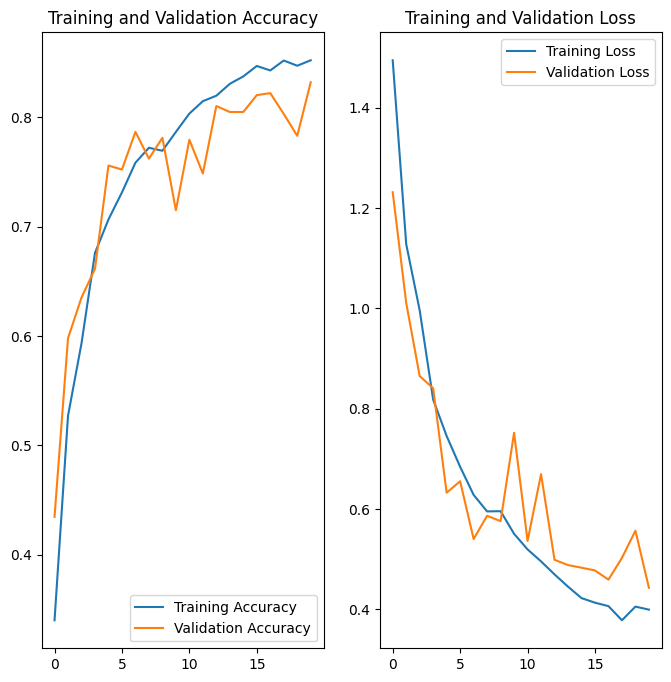

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
